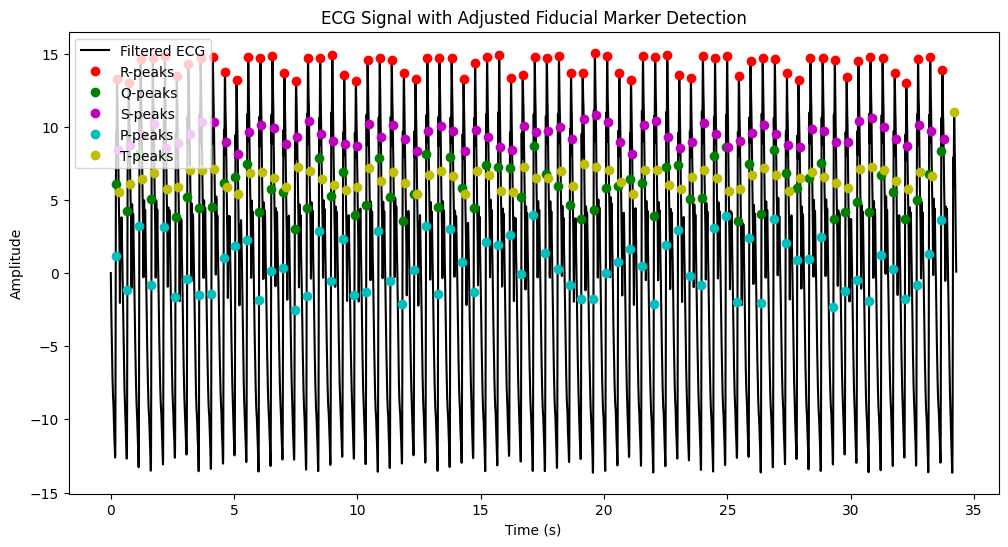

Detected R-peaks indices: [  51  145  242  340  439  535  630  728  827  926 1020 1115 1213 1311
 1408 1502 1599 1698 1796 1893 1987 2082 2181 2278 2376 2471 2567 2665
 2764 2861 2954 3052 3150 3246 3340 3438 3536 3634 3732 3826 3925 4025
 4124 4219 4315 4414 4513 4610 4704 4801 4900 4998 5093 5188 5286 5385
 5483 5577 5674 5773 5871 5967 6062 6160 6259 6357 6451 6546 6645 6744]
Detected Q-peaks indices: [np.int64(41), np.int64(135), np.int64(232), np.int64(330), np.int64(429), np.int64(525), np.int64(620), np.int64(718), np.int64(817), np.int64(916), np.int64(1010), np.int64(1105), np.int64(1203), np.int64(1301), np.int64(1398), np.int64(1492), np.int64(1589), np.int64(1688), np.int64(1786), np.int64(1883), np.int64(1977), np.int64(2072), np.int64(2171), np.int64(2268), np.int64(2366), np.int64(2461), np.int64(2557), np.int64(2655), np.int64(2754), np.int64(2851), np.int64(2944), np.int64(3042), np.int64(3140), np.int64(3236), np.int64(3330), np.int64(3428), np.int64(3526), np.int64(3

In [6]:
import pandas as pd
import numpy as np
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt

# --- Load the ECG data from "3seconds Adrenaline.txt" ---
data = pd.read_csv("3seconds Adrenaline.txt", sep="\t", header=None, decimal=',')
# Assumes the ECG signal is in the second column (index 1)
ecg_signal = data.iloc[:, 1].values

# --- Determine sampling rate ---
# Based on the time stamps (first column), the sampling rate is about 200 Hz.
sampling_rate = 200

# --- Process the ECG signal with BioSPPy ---
out = ecg.ecg(signal=ecg_signal, sampling_rate=sampling_rate, show=False)
filtered = out['filtered']
rpeaks = out['rpeaks']

# --- Define heuristic windows (in seconds) for the current adrenaline data ---
# These values have been tuned for a faster rate and narrower complexes.
q_search_before_R = 0.05   # 50 ms before R for Q detection
s_search_after_R  = 0.05   # 50 ms after R for S detection
p_search_window   = 0.15   # 150 ms window before Q for P detection
# Instead of a fixed t window, we now use the interval between S and the next R (minus a margin)

# Convert time windows to samples.
q_window = int(q_search_before_R * sampling_rate)
s_window = int(s_search_after_R * sampling_rate)
p_window = int(p_search_window * sampling_rate)
# For T detection, we'll use an offset and margin relative to S and the next R.

p_peaks = []
q_peaks = []
s_peaks = []
t_peaks = []

# Iterate over each R-peak using its index so that we can reference the next beat.
for i, r in enumerate(rpeaks):
    # --- Q-peak: local minimum between r - q_window and r.
    start_q = max(r - q_window, 0)
    end_q = r
    q_index = np.argmin(filtered[start_q:end_q]) + start_q
    q_peaks.append(q_index)
    
    # --- S-peak: local minimum between r and r + s_window.
    start_s = r
    end_s = min(r + s_window, len(filtered))
    s_index = np.argmin(filtered[start_s:end_s]) + start_s
    s_peaks.append(s_index)
    
    # --- P-peak: local maximum in the window before Q.
    start_p = max(q_index - p_window, 0)
    end_p = q_index
    p_index = np.argmax(filtered[start_p:end_p]) + start_p
    p_peaks.append(p_index)
    
    # --- T-peak: define the window from a short time after S up to just before the next R.
    if i < len(rpeaks) - 1:
        next_r = rpeaks[i+1]
    else:
        next_r = len(filtered)
    # Use a small offset after S to avoid the S-wave itself
    t_offset = int(0.02 * sampling_rate)  # 20 ms offset
    # Use a margin before the next R to avoid picking the next R peak
    margin = int(0.05 * sampling_rate)      # 50 ms margin
    start_t = s_index + t_offset
    end_t = max(next_r - margin, start_t + 1)
    t_index = np.argmax(filtered[start_t:end_t]) + start_t
    t_peaks.append(t_index)

# --- Plotting the results ---
time = np.arange(len(filtered)) / sampling_rate
plt.figure(figsize=(12, 6))
plt.plot(time, filtered, label="Filtered ECG", color="black")
plt.plot(np.array(rpeaks)/sampling_rate, filtered[rpeaks], 'ro', label="R-peaks")
plt.plot(np.array(q_peaks)/sampling_rate, filtered[q_peaks], 'go', label="Q-peaks")
plt.plot(np.array(s_peaks)/sampling_rate, filtered[s_peaks], 'mo', label="S-peaks")
plt.plot(np.array(p_peaks)/sampling_rate, filtered[p_peaks], 'co', label="P-peaks")
plt.plot(np.array(t_peaks)/sampling_rate, filtered[t_peaks], 'yo', label="T-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Adjusted Fiducial Marker Detection")
plt.legend()
plt.show()

print("Detected R-peaks indices:", rpeaks)
print("Detected Q-peaks indices:", q_peaks)
print("Detected S-peaks indices:", s_peaks)
print("Detected P-peaks indices:", p_peaks)
print("Detected T-peaks indices:", t_peaks)
